<a href="https://colab.research.google.com/github/islammohamedd1/gp/blob/main/stocks_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stocks Prediction

In [1]:
import IPython
import IPython.display

%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, Bidirectional, Dropout, BatchNormalization, Reshape
from tensorflow.keras.utils import plot_model 
import re

In [2]:
matplotlib.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.figsize'] = [12, 8]

## Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('/content/drive/MyDrive/GP/Datasets/nflx_prices.csv', index_col='Date', parse_dates=['Date'], date_parser=dateparse)
print(len(df))

1395


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [5]:
df = df.rename(columns={'Open': 'open', 'Close': 'close', 'High': 'high', 'Low': 'low', 'Volume': 'volume'})
df = df.drop(columns=['Adj Close'])

In [6]:
df.head()

,open,high,low,close,volume
Date,,,,,
2015-12-17,123.970001,126.349998,122.419998,122.510002,17284900
2015-12-18,120.849998,122.190002,117.919998,118.019997,17948100
2015-12-21,119.510002,119.589996,115.660004,116.629997,11670000
2015-12-22,117.300003,117.430000,114.860001,116.239998,9689000
2015-12-23,116.910004,118.559998,115.779999,118.160004,9324300


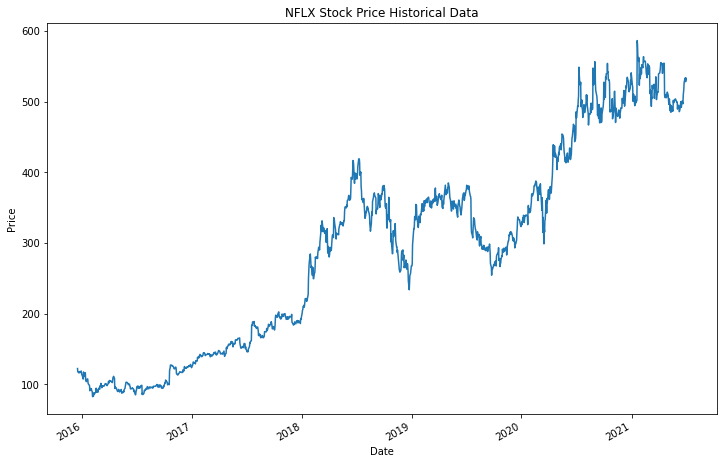

In [7]:
df['close'].plot()
plt.title('NFLX Stock Price Historical Data')
plt.ylabel('Price')
plt.show()

In [8]:
df.describe()

,open,high,low,close,volume
count,1395.000000,1395.000000,1395.000000,1395.000000,1.395000e+03
mean,293.922860,298.350286,289.277369,293.968940,8.715550e+06
std,143.795207,145.979171,141.477577,143.767086,6.051820e+06
min,80.570000,84.699997,79.949997,82.790001,6.626940e+05
25%,151.489998,153.360001,149.099998,151.904999,4.852400e+06
50%,308.429993,313.989990,303.239990,309.100006,6.954100e+06
75%,378.604996,384.440002,374.610001,379.944992,1.050730e+07
max,582.450012,593.289978,570.400024,586.340027,5.841040e+07


In [9]:
df['change'] = df.close.pct_change()

In [10]:
df[['change', 'close']].head()

,change,close
Date,,
2015-12-17,NaN,122.510002
2015-12-18,-0.036650,118.019997
2015-12-21,-0.011778,116.629997
2015-12-22,-0.003344,116.239998
2015-12-23,0.016518,118.160004


In [11]:
df.dropna(inplace=True)

## News Data

In [12]:
news_df = pd.read_csv('/content/drive/MyDrive/GP/Datasets/analyzed_news.csv', index_col=0)
news_df.head()

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,title,date,stock,sentiment
0,Stocks That Hit 52-Week Highs On Friday,2020-06-05,A,"(<tf.Tensor: shape=(), dtype=float32, numpy=0...."
1,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03,A,"(<tf.Tensor: shape=(), dtype=float32, numpy=0...."
2,71 Biggest Movers From Friday,2020-05-26,A,"(<tf.Tensor: shape=(), dtype=float32, numpy=0...."
3,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22,A,"(<tf.Tensor: shape=(), dtype=float32, numpy=0...."
4,B of A Securities Maintains Neutral on Agilent...,2020-05-22,A,"(<tf.Tensor: shape=(), dtype=float32, numpy=0...."


In [13]:
news_df.where(news_df['stock'] == 'NFLX').dropna().shape

(3009, 4)

In [14]:
news_df.groupby(['stock']).count().sort_values(by=['date'], ascending=False).head(50)

,title,date,sentiment
stock,,,
MRK,3334,3334,3334
MS,3242,3242,3242
MU,3144,3144,3144
NVDA,3133,3133,3133
QQQ,3100,3100,3100
M,3078,3078,3078
EBAY,3021,3021,3021
NFLX,3009,3009,3009
GILD,2969,2969,2969


In [15]:
news_df = news_df.where(news_df['stock'] == 'NFLX').dropna()
print(len(news_df))
news_df.head()

3009


,title,date,stock,sentiment
885221,As Expected: Fed Keeps Rates Unchanged and For...,2020-06-10,NFLX,"(<tf.Tensor: shape=(), dtype=float32, numpy=0...."
885222,Hearing JP Morgan Reiterates Overweight Rating...,2020-06-10,NFLX,"(<tf.Tensor: shape=(), dtype=float32, numpy=0...."
885223,Netflix Option Trader Makes $73.6M Bet On 5% U...,2020-06-09,NFLX,"(<tf.Tensor: shape=(), dtype=float32, numpy=0...."
885224,Netflix shares are trading higher. The stock s...,2020-06-09,NFLX,"(<tf.Tensor: shape=(), dtype=float32, numpy=0...."
885225,Munster Says Under-The-Radar Apple TV+ Will Co...,2020-06-08,NFLX,"(<tf.Tensor: shape=(), dtype=float32, numpy=0...."


In [16]:
news_df['date'].nunique()

913

In [17]:
news_df['sentiment'] = news_df['sentiment'].apply(lambda x: float(re.findall('\d+\.\d+', x)[0]))

In [18]:
news_df.dtypes

title         object
date          object
stock         object
sentiment    float64
dtype: object

In [19]:
news_df.head(1)

,title,date,stock,sentiment
885221,As Expected: Fed Keeps Rates Unchanged and For...,2020-06-10,NFLX,0.997275


In [20]:
news_df.describe()

,sentiment
count,3009.000000
mean,0.894246
std,0.274988
min,0.000138
25%,0.991010
50%,0.999418
75%,0.999848
max,0.999959


In [21]:
grouped_df = pd.DataFrame(news_df.groupby(['date']).mean())
grouped_df.head()

,sentiment
date,
2016-08-23,0.507650
2016-08-24,0.999825
2016-08-25,0.991956
2016-08-29,0.997951
2016-08-30,0.993643


In [22]:
df.loc['2016-08-23':].shape

(1224, 6)

In [23]:
joined_df = df.join(grouped_df)
print(len(joined_df))
joined_df.head()

1394


,open,high,low,close,volume,change,sentiment
Date,,,,,,,
2015-12-18,120.849998,122.190002,117.919998,118.019997,17948100,-0.036650,NaN
2015-12-21,119.510002,119.589996,115.660004,116.629997,11670000,-0.011778,NaN
2015-12-22,117.300003,117.430000,114.860001,116.239998,9689000,-0.003344,NaN
2015-12-23,116.910004,118.559998,115.779999,118.160004,9324300,0.016518,NaN
2015-12-24,118.220001,118.800003,117.300003,117.330002,3531300,-0.007024,NaN


In [24]:
joined_df['sentiment'] = joined_df['sentiment'].fillna(-1)
joined_df.head()

,open,high,low,close,volume,change,sentiment
Date,,,,,,,
2015-12-18,120.849998,122.190002,117.919998,118.019997,17948100,-0.036650,-1.0
2015-12-21,119.510002,119.589996,115.660004,116.629997,11670000,-0.011778,-1.0
2015-12-22,117.300003,117.430000,114.860001,116.239998,9689000,-0.003344,-1.0
2015-12-23,116.910004,118.559998,115.779999,118.160004,9324300,0.016518,-1.0
2015-12-24,118.220001,118.800003,117.300003,117.330002,3531300,-0.007024,-1.0


In [25]:
joined_df['sentiment'].value_counts()

-1.000000    612
 0.999849      3
 0.999927      2
 0.999861      2
 0.999934      2
            ... 
 0.999909      1
 0.998558      1
 0.499854      1
 0.800088      1
 0.999933      1
Name: sentiment, Length: 777, dtype: int64

## Grouping the data

In [26]:
df = joined_df

In [27]:
df.drop(columns=['open', 'high', 'low'], inplace=True)

In [28]:
close_scaler = MinMaxScaler()
volume_scaler = MinMaxScaler()
change_scaler = MinMaxScaler()
df.close = close_scaler.fit_transform(df.close.values.reshape(-1, 1))
df.volume = volume_scaler.fit_transform(df.volume.values.reshape(-1, 1))
df.change = change_scaler.fit_transform(df.change.values.reshape(-1, 1))

Split the data using (70, 20, 10)

In [29]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
num_features

4

In [30]:
train_df.head()

,close,volume,change,sentiment
Date,,,,
2015-12-18,0.069963,0.299326,0.294244,-1.0
2015-12-21,0.067203,0.190610,0.371597,-1.0
2015-12-22,0.066428,0.156306,0.397826,-1.0
2015-12-23,0.070241,0.149990,0.459596,-1.0
2015-12-24,0.068593,0.049675,0.386380,-1.0


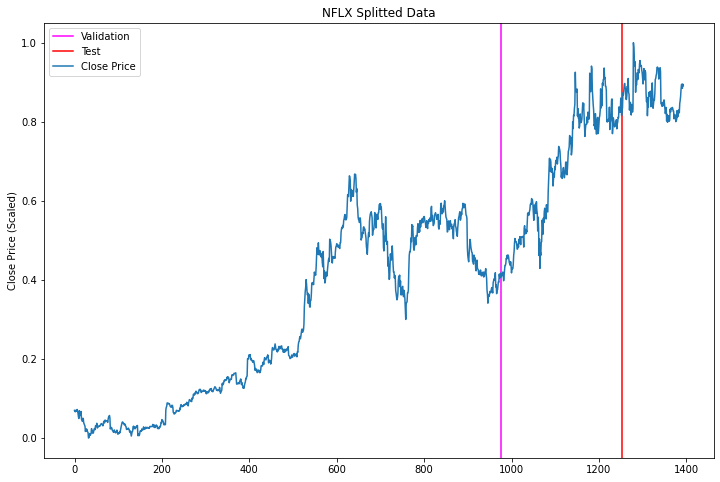

In [31]:
plt.axvline(x=len(train_df), color='magenta')
plt.axvline(x=len(train_df) + len(val_df), color='red')
plt.plot(range(len(df)), df.close)
plt.legend(['Validation', 'Test', 'Close Price'])
plt.title('NFLX Splitted Data')
plt.ylabel('Close Price (Scaled)')
plt.show()

## Window Generator

In [32]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df=train_df, 
                 val_df=val_df, test_df=test_df, label_columns=None):
        # Store the raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        # wirk out the label column indices
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i,
                                          name in enumerate(label_columns)}
        self.column_indices = {name: i for i,
                               name in enumerate(train_df.columns)}
        
        # work out the window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [33]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=256,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [34]:
def plot(self, model=None, plot_col='close', max_subplots=3, title=None):
    inputs, labels = self.example
    # plt.figure(figsize=(24, 32))
    if title:
        plt.suptitle(title)
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_subplots, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()
    
    plt.xlabel('Time')
    plt.show()

WindowGenerator.plot = plot

In [35]:
def plot_series(self, model, plot_col='close', series=test_df, start=0, title=None):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(self.total_window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(self.total_window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    forecast = forecast[:-1, -1, 0]
    plt.plot(np.array(range(len(series[plot_col][start + self.input_width + self.label_width:]))), 
                series[plot_col][start + self.input_width + self.label_width:], '-')
    plt.plot(np.array(range(len(forecast[start:]))), forecast[start:], '-')

    plt.title(title)
    plt.legend(['Actual', 'Prediction'])
    plt.xlabel('Time')
    plt.show()

        
WindowGenerator.plot_series = plot_series

In [36]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [37]:
val_performance = {}
performance = {}

In [38]:
MAX_EPOCHS = 1000

def compile_and_fit(model, window, patience=5):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min',
                                                      restore_best_weights=True)

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(),
                         tf.metrics.MeanAbsolutePercentageError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

## Multi-Step Models

### Window the data

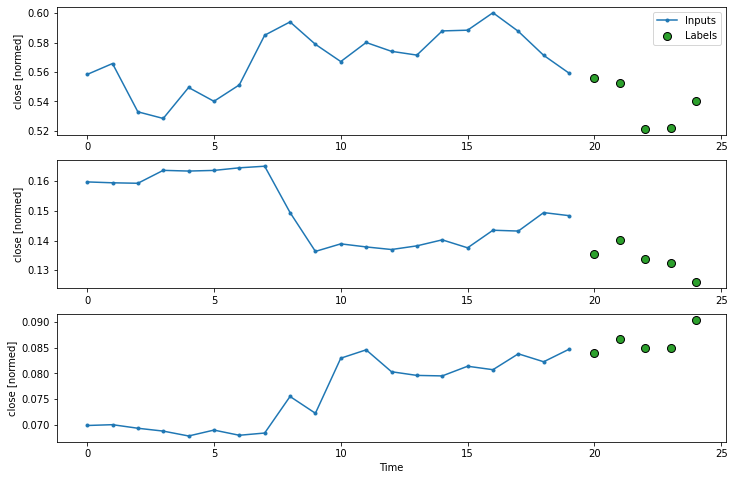

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Label indices: [20 21 22 23 24]
Label column name(s): ['close']

In [39]:
OUT_STEPS = 5
multi_window = WindowGenerator(input_width=20, label_width=OUT_STEPS,
                               shift=OUT_STEPS, label_columns=['close'])
multi_window.plot()
multi_window

In [40]:
multi_val_performance = {}
multi_performance = {}

### Dense model

In [41]:
multi_dense_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)

1/1 [==============================] - 0s 57ms/step - loss: 0.0014 - mean_absolute_error: 0.0285 - mean_absolute_percentage_error: 4.1221


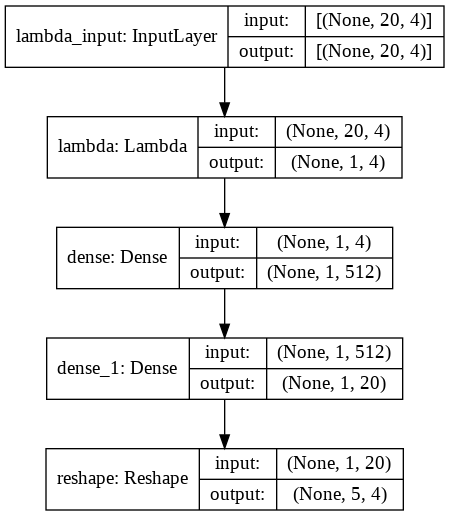

In [42]:
plot_model(multi_dense_model, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

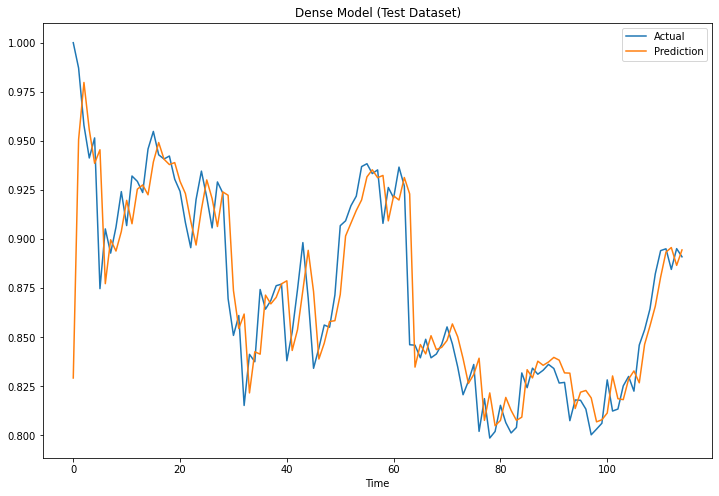

In [43]:
multi_window.plot_series(multi_dense_model, title="Dense Model (Test Dataset)")

### CNN

In [44]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(512, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)

1/1 [==============================] - 0s 55ms/step - loss: 0.0020 - mean_absolute_error: 0.0333 - mean_absolute_percentage_error: 4.7391


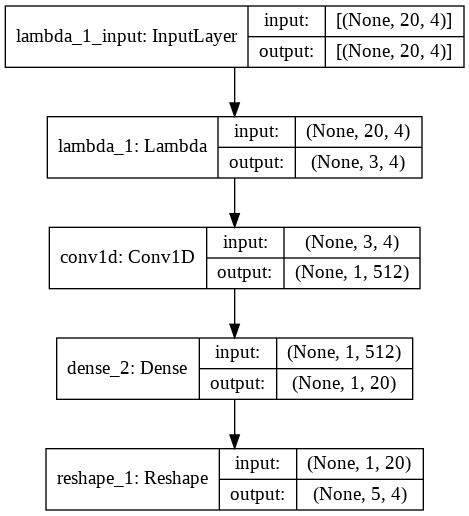

In [45]:
plot_model(multi_conv_model, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

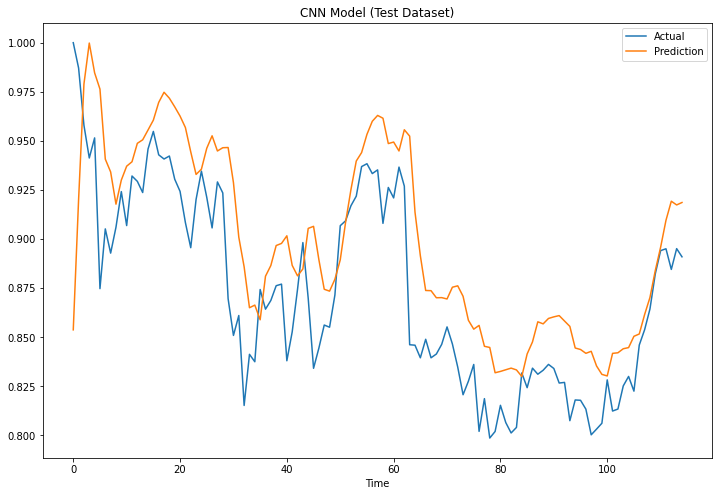

In [46]:
multi_window.plot_series(multi_conv_model, title="CNN Model (Test Dataset)", start=0)

### RNN LSTM

In [47]:
tf.keras.backend.clear_session()
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(1024, return_sequences=True),
    tf.keras.layers.LSTM(512, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

1/1 [==============================] - 0s 62ms/step - loss: 0.0031 - mean_absolute_error: 0.0430 - mean_absolute_percentage_error: 6.2260


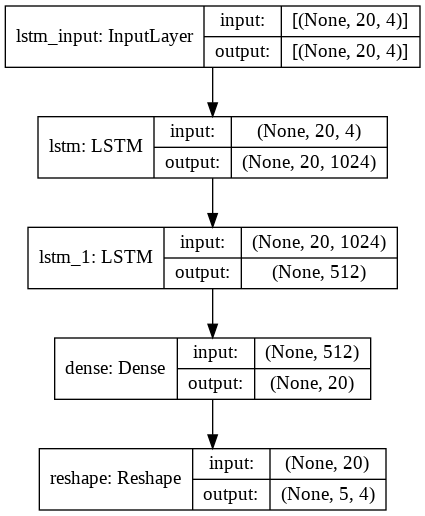

In [48]:
plot_model(multi_lstm_model, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

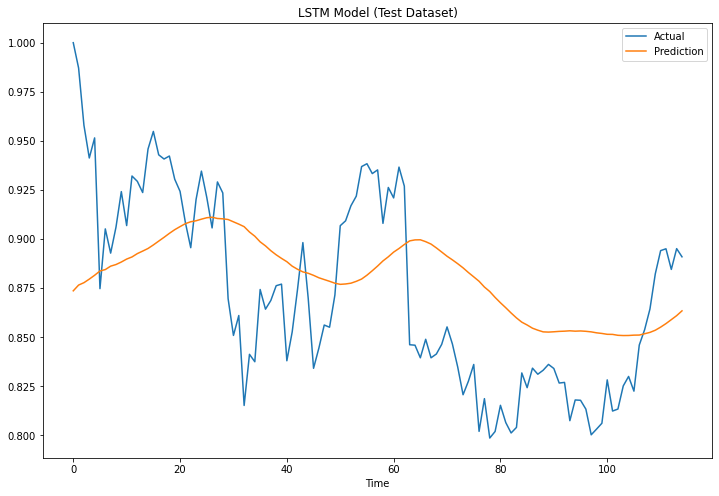

In [49]:
multi_window.plot_series(multi_lstm_model, title="LSTM Model (Test Dataset)")

### Bidirectional LSTM

In [50]:
tf.keras.backend.clear_session()
bidirectional_lstm_model = tf.keras.Sequential([
    Bidirectional(LSTM(1024, return_sequences=True)),
    Bidirectional(LSTM(512, return_sequences=False)),
    Dense(OUT_STEPS*num_features, activation='tanh'),
    Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(bidirectional_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['BIDIRECTIONAL_LSTM'] = bidirectional_lstm_model.evaluate(multi_window.val)
multi_performance['BIDIRECTIONAL_LSTM'] = bidirectional_lstm_model.evaluate(multi_window.test, verbose=0)

1/1 [==============================] - 0s 73ms/step - loss: 0.0051 - mean_absolute_error: 0.0572 - mean_absolute_percentage_error: 9.0358


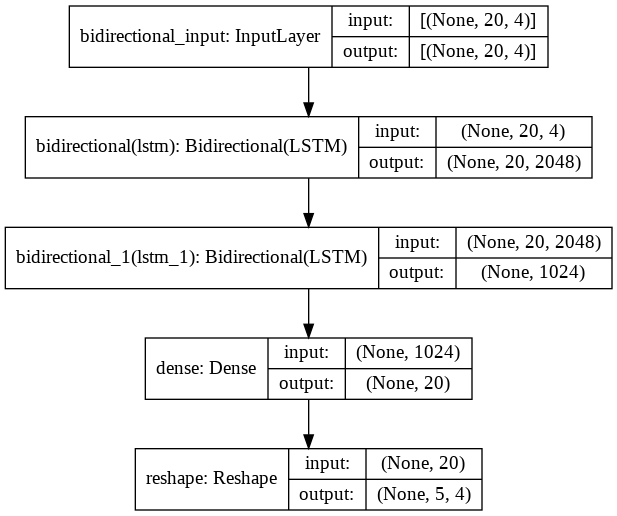

In [51]:
plot_model(bidirectional_lstm_model, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

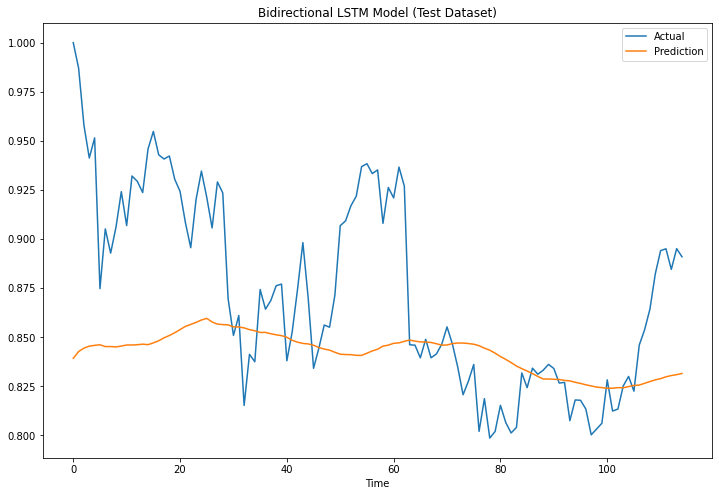

In [52]:
multi_window.plot_series(bidirectional_lstm_model, title="Bidirectional LSTM Model (Test Dataset)", start=0)

### GRU

In [53]:
tf.keras.backend.clear_session()

gru_model = tf.keras.Sequential([
    GRU(2048, return_sequences=True),
    Dropout(0.5), ## Note the performance without dropout
    GRU(1024, return_sequences=False),
    Dropout(0.5),
    Dense(OUT_STEPS*num_features),
    Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(gru_model, multi_window)

IPython.display.clear_output()

multi_val_performance['GRU'] = gru_model.evaluate(multi_window.val)
multi_performance['GRU'] = gru_model.evaluate(multi_window.test, verbose=0)

1/1 [==============================] - 0s 80ms/step - loss: 0.0015 - mean_absolute_error: 0.0289 - mean_absolute_percentage_error: 4.1782


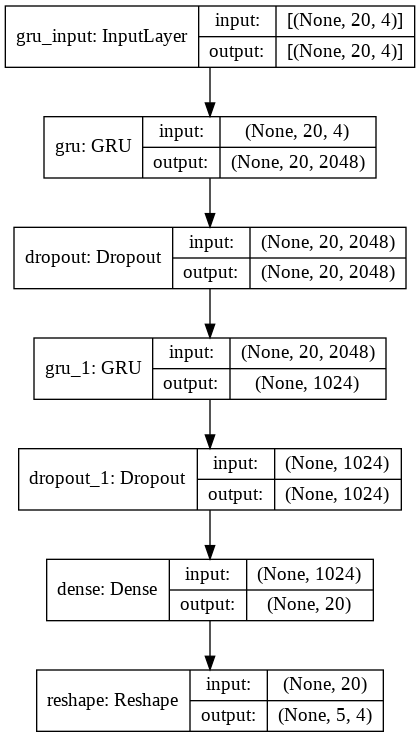

In [54]:
plot_model(gru_model, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [55]:
multi_performance['GRU']

[0.0015278421342372894, 0.026602376252412796, 3.0096373558044434]

Prices Only:
[0.0019513261504471302, 0.032110683619976044, 3.610513210296631]


With Change only
[0.0015289634466171265, 0.027325019240379333, 3.104872226715088]


With sentiment only
[0.0016269683837890625, 0.02839045412838459, 3.2270796298980713]


With change and Sentiment
[0.0015278421342372894, 0.026602376252412796, 3.0096373558044434]



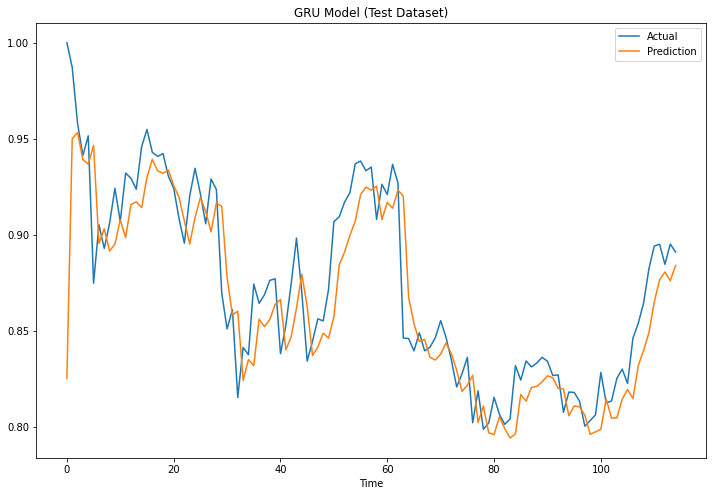

In [56]:
multi_window.plot_series(gru_model, title="GRU Model (Test Dataset)")

### Bidirectional GRU

In [57]:
tf.keras.backend.clear_session()

bidirectinoal_gru_model = tf.keras.Sequential([
    Bidirectional(GRU(2048, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(GRU(1024, return_sequences=False)),
    Dropout(0.5),
    Dense(OUT_STEPS*num_features),
    Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(bidirectinoal_gru_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Bidirectional_GRU'] = bidirectinoal_gru_model.evaluate(multi_window.val)
multi_performance['Bidirectional_GRU'] = bidirectinoal_gru_model.evaluate(multi_window.test, verbose=0)

1/1 [==============================] - 0s 102ms/step - loss: 0.0016 - mean_absolute_error: 0.0301 - mean_absolute_percentage_error: 4.3714


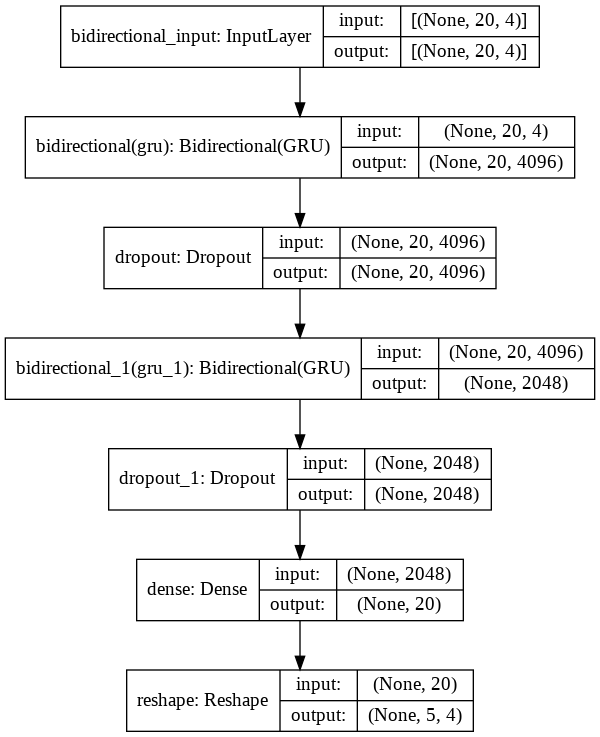

In [58]:
plot_model(bidirectinoal_gru_model, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [59]:
multi_performance['Bidirectional_GRU']

[0.001631676102988422, 0.029831692576408386, 3.4119179248809814]

Prices Only
[0.0023532784543931484, 0.03825841844081879, 4.412179470062256]

Prices and Sentiment Only
[0.0018242188962176442, 0.03301664814352989, 3.803429365158081]


Prices and Change Only
[0.001736925565637648, 0.03196527436375618, 3.6692416667938232]

Prices, Change and Sentiment
[0.0016315558459609747, 0.029971031472086906, 3.41367506980896]


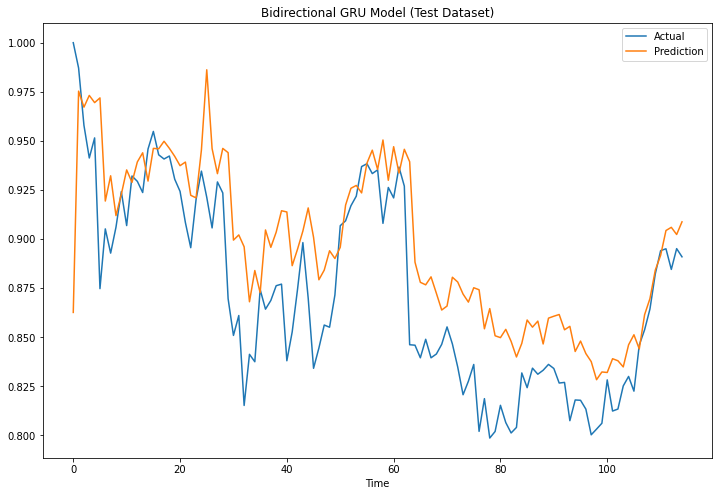

In [60]:
multi_window.plot_series(bidirectinoal_gru_model, title="Bidirectional GRU Model (Test Dataset)")

## Summary

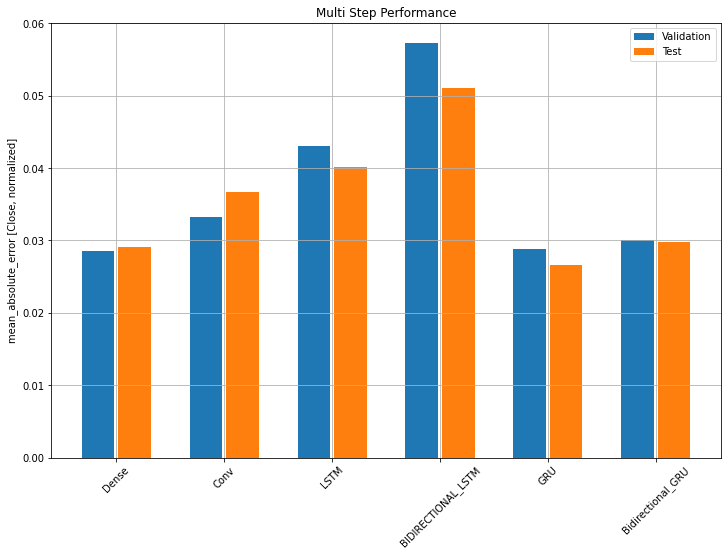

In [61]:
x = np.arange(len(multi_performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.grid()
plt.title('Multi Step Performance')
plt.ylabel('mean_absolute_error [Close, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
_ = plt.legend()

In [62]:
for l, v in zip(multi_performance.keys(), test_mae):
    print(l, v)

Dense 0.029144925996661186
Conv 0.036627981811761856
LSTM 0.04013768956065178
BIDIRECTIONAL_LSTM 0.05111364647746086
GRU 0.026602376252412796
Bidirectional_GRU 0.029831692576408386


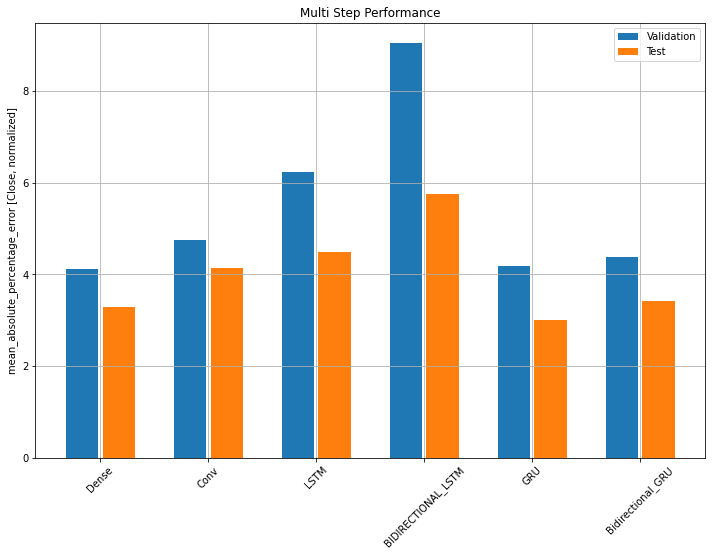

In [63]:
x = np.arange(len(multi_performance))
width = 0.3
metric_name = 'mean_absolute_percentage_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_percentage_error')
val_mape = [v[metric_index] for v in multi_val_performance.values()]
test_mape = [v[metric_index] for v in multi_performance.values()]

plt.grid()
plt.title('Multi Step Performance')
plt.ylabel('mean_absolute_percentage_error [Close, normalized]')
plt.bar(x - 0.17, val_mape, width, label='Validation')
plt.bar(x + 0.17, test_mape, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
_ = plt.legend()

In [64]:
for l, v in zip(multi_performance.keys(), test_mape):
    print(l, v)

Dense 3.2892112731933594
Conv 4.140725612640381
LSTM 4.482527732849121
BIDIRECTIONAL_LSTM 5.754342555999756
GRU 3.0096373558044434
Bidirectional_GRU 3.4119179248809814


In [65]:
multi_dense_model.save('/content/drive/MyDrive/GP/models/time_series/dense')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/GP/models/time_series/dense/assets


In [66]:
multi_conv_model.save('/content/drive/MyDrive/GP/models/time_series/cnn')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/GP/models/time_series/cnn/assets


In [67]:
multi_lstm_model.save('/content/drive/MyDrive/GP/models/time_series/lstm')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/GP/models/time_series/lstm/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/GP/models/time_series/lstm/assets


In [68]:
bidirectional_lstm_model.save('/content/drive/MyDrive/GP/models/time_series/bidirectional_lstm')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/GP/models/time_series/bidirectional_lstm/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/GP/models/time_series/bidirectional_lstm/assets


In [69]:
gru_model.save('/content/drive/MyDrive/GP/models/time_series/gru')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/GP/models/time_series/gru/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/GP/models/time_series/gru/assets


In [70]:
bidirectinoal_gru_model.save('/content/drive/MyDrive/GP/models/time_series/bidirectional_gru')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/GP/models/time_series/bidirectional_gru/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/GP/models/time_series/bidirectional_gru/assets
